In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from PIL import Image
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D, ZeroPadding2D, Activation, concatenate, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from random import shuffle

In [2]:
class Data:
    def __init__(self, tag):
        self.id = tag
        self.MASKED_GFC_FSEG_TRA_90 = None
        self.SBJ_SAG_88 = None
        self.T88_GFC_COR_110 = None
        self.T88_GFC_SAG_95 = None
        self.T88_GFC_TRA_90 = None
        self.T88_MASKED_GFC_TRA_90 = None
        self.sex = None
        self.hand = None
        self.age = None
        self.educ = None
        self.SES = None
        self.MMSE = None
        self.CDR = None
        self.eTIV = None
        self.nWBV = None
        self.ASF = None
        self.Delay = None

In [3]:
path = '/kaggle/input/ad-2d-dataset/dataset1'
dir_list = os.listdir(path)

filt_list = []

for i in dir_list:
    filt_list.append(i)

In [4]:
data_dict = {}
xc = 176
yc = 176

# for i in filt_list:
#     ob = Data(i)
#     directory = path + '//' + i
#     ob.MASKED_GFC_FSEG_TRA_90 = np.array(Image.open(directory + '//' + i + '_MASKED_GFC_FSEG_TRA_90.gif').resize((xc, yc)))/255
#     ob.SBJ_SAG_88 = np.array(Image.open(directory + '//' + i + '_SBJ_SAG_88.gif').resize((xc,yc)))/255
#     ob.T88_GFC_COR_110 = np.array(Image.open(directory + '//' + i + '_T88_GFC_COR_110.gif').resize((xc,yc)))/255
#     ob.T88_GFC_SAG_95 = np.array(Image.open(directory + '//' + i + '_T88_GFC_SAG_95.gif').resize((xc,yc)))/255
#     ob.T88_GFC_TRA_90 = np.array(Image.open(directory + '//' + i + '_T88_GFC_TRA_90.gif').resize((xc,yc)))/255
#     ob.T88_MASKED_GFC_TRA_90 = np.array(Image.open(directory + '//' + i + '_T88_MASKED_GFC_TRA_90.gif').resize((xc,yc)))/255
#     data_dict[i] = ob

for i in filt_list:
    ob = Data(i)
    directory = path + '//' + i
    ob.T88_GFC_COR_110 = np.array(Image.open(directory + '//' + i + '_T88_GFC_COR_110.gif').resize((xc,yc)))/255
    ob.T88_GFC_SAG_95 = np.array(Image.open(directory + '//' + i + '_T88_GFC_SAG_95.gif').resize((xc,yc)))/255
    ob.T88_MASKED_GFC_TRA_90 = np.array(Image.open(directory + '//' + i + '_T88_MASKED_GFC_TRA_90.gif').resize((xc,yc)))/255
    data_dict[i] = ob

In [5]:
df = pd.read_csv('/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv')

In [6]:
df = df.reset_index()
for index, row in df.iterrows():
    tag = row['ID']
    ob = data_dict[tag]
    ob.sex = row['M/F']
    ob.hand = row['Hand']
    ob.age = row['Age']
    ob.educ = row['Educ']
    ob.SES = row['SES']
    ob.MMSE = row['MMSE']
    ob.CDR = row['CDR']
    ob.eTIV = row['eTIV']
    ob.nWBV = row['nWBV']
    ob.ASF = row['ASF']
    ob.Delay = row['Delay']

In [17]:
X = []
LABEL = []

for k,ob in data_dict.items():
#     t = [ob.T88_GFC_COR_110, ob.T88_GFC_SAG_95, ob.T88_MASKED_GFC_TRA_90]
#     shuffle(t)
#     X.append(np.hstack(t))
#     X.append(np.vstack([np.hstack(t[:3]), np.hstack(t[3:])]))
#     X.append(ob.MASKED_GFC_FSEG_TRA_90)
#     X.append(ob.SBJ_SAG_88)
#     X.append(ob.T88_GFC_COR_110)
#     X.append(ob.T88_GFC_SAG_95)
#     X.append(ob.T88_MASKED_GFC_TRA_90)
    X.append(ob.T88_MASKED_GFC_TRA_90)
    temp = None
    if ob.CDR > 0:
        if ob.CDR == 0.5:
            temp = 1
        else:
            temp = 2
    else:
        temp = 0
    LABEL.extend([temp]*1)
    
X = np.array(X)
Y = tf.keras.utils.to_categorical(LABEL, 3)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=64, stratify = Y)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [19]:
def getMultiscaleBlock(prev_layer, dilation_rate):
    aconv_1 = Conv2D(32, kernel_size=(1, 1), activation="relu", padding="SAME")(prev_layer)
    aconv_1 = BatchNormalization()(aconv_1)
    
    aconv_2 = Conv2D(64, kernel_size=(3, 3), activation="relu", dilation_rate = dilation_rate, padding="SAME")(aconv_1)
    aconv_2 = BatchNormalization()(aconv_2)
    
    aconv_3 = Conv2D(64, kernel_size=(1, 1), activation="relu", padding="SAME")(aconv_2)
    aconv_3 = BatchNormalization()(aconv_3)
    
    return aconv_3

In [20]:
input_layer = keras.Input(shape=[x_train.shape[1], x_train.shape[2], 1])

conv_1 = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="SAME")(input_layer)

aconv_1 = getMultiscaleBlock(conv_1, 1)
aconv_2 = getMultiscaleBlock(conv_1, 2)
aconv_3 = getMultiscaleBlock(conv_1, 4)

merge_1 = concatenate([aconv_1, aconv_2, aconv_3])

conv_2 = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="SAME")(merge_1)
conv_2 = BatchNormalization()(conv_2)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="SAME")(conv_2)
conv_2 = BatchNormalization()(conv_2)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="SAME")(conv_2)
conv_2 = BatchNormalization()(conv_2)
conv_2 = MaxPooling2D(pool_size=(2, 2), padding="VALID")(conv_2)

conv_3 = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="SAME")(conv_2)
conv_3 = BatchNormalization()(conv_3)
conv_3 = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="SAME")(conv_3)
conv_3 = BatchNormalization()(conv_3)
conv_3 = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="SAME")(conv_3)
conv_3 = BatchNormalization()(conv_3)
conv_3 = MaxPooling2D(pool_size=(2, 2), padding="VALID")(conv_3)

conv_4 = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="SAME")(conv_3)
conv_4 = BatchNormalization()(conv_4)

dConv_5 = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="SAME")(conv_4)
dConv_5 = BatchNormalization()(dConv_5)
dConv_5 = concatenate([dConv_5, conv_3])
dConv_5 = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="SAME")(dConv_5)

dConv_6 = UpSampling2D(size=(2, 2))(dConv_5)
dConv_6 = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="SAME")(dConv_6)
dConv_6 = BatchNormalization()(dConv_6)
dConv_6 = concatenate([dConv_6, conv_2])
dConv_6 = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="SAME")(dConv_6)

dConv_7 = UpSampling2D(size=(2, 2))(dConv_6)
dConv_7 = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="SAME")(dConv_7)
dConv_7 = BatchNormalization()(dConv_7)
dConv_7 = concatenate([dConv_7, merge_1])
dConv_7 = Conv2D(64, kernel_size=(3, 3), activation="relu", padding="SAME")(dConv_7)

output = Conv2D(32, kernel_size=(3, 3), activation="relu", padding="SAME")(dConv_7)
output = Conv2D(16, kernel_size=(3, 3), activation="relu", padding="SAME")(output)
output = Conv2D(1, kernel_size=(3, 3), activation="sigmoid", padding="SAME")(output)
output = MaxPooling2D(pool_size=(3, 3), padding="VALID")(output)
output = Flatten()(output)
output = Dense(128, activation="relu")(output)
output = Dense(32, activation="relu")(output)
output = Dense(3, activation="softmax")(output)
model = tf.keras.Model(inputs=input_layer, outputs=output)
initial_learning_rate = 0.0001 
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True) 
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics=["acc"])

model = Model(inputs=input_layer, outputs=output)

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 176, 176, 1) 0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 176, 176, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 176, 176, 32) 2080        conv2d_26[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 176, 176, 32) 2080        conv2d_26[0][0]                  
____________________________________________________________________________________________

In [22]:
sm = SMOTE(random_state=42)
x_train_reshaped = x_train.reshape(x_train.shape[0],-1)
x_smote, y_smote = sm.fit_resample(x_train_reshaped, y_train)
x_smote = x_smote.reshape(-1, x_train.shape[1], x_train.shape[2])

In [23]:
x_train_smote, x_val_smote, y_train_smote, y_val_smote = train_test_split(x_smote, y_smote, test_size = 0.2, random_state=32, stratify = y_smote)

In [24]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train_smote, y_train_smote))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val_smote, y_val_smote))

batch_size = 16
train_dataset = (
    train_loader.shuffle(len(x_train_smote))
    .batch(batch_size)
    .prefetch(16)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val_smote))
    .batch(batch_size)
    .prefetch(16)
)

batch_size = 32
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model_result = model.fit(x_smote, y_smote, 
                         batch_size=batch_size,
                         epochs=epochs,
                         validation_split=0.15)

model.save('ad-classify-1.h5')

inp_layer = Input(shape=[x_train.shape[1], x_train.shape[2], 1])

nModel = tf.keras.applications.ResNet152V2(
    include_top=True,
    weights=None,
    input_tensor=inp_layer,
    input_shape=None,
    pooling=None,
    classes=1,
    classifier_activation="sigmoid",
)


In [25]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "2d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

In [26]:
epochs = 25
model_history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/25
41/41 [==============================] - 18s 312ms/step - loss: 1.0436 - acc: 0.4619 - val_loss: 1.1070 - val_acc: 0.3354
Epoch 2/25
41/41 [==============================] - 11s 269ms/step - loss: 0.7076 - acc: 0.7465 - val_loss: 1.2649 - val_acc: 0.3354
Epoch 3/25
41/41 [==============================] - 11s 268ms/step - loss: 0.4096 - acc: 0.8942 - val_loss: 1.3658 - val_acc: 0.3292
Epoch 4/25
41/41 [==============================] - 11s 268ms/step - loss: 0.2188 - acc: 0.9549 - val_loss: 1.6352 - val_acc: 0.3292
Epoch 5/25
41/41 [==============================] - 11s 268ms/step - loss: 0.2396 - acc: 0.9549 - val_loss: 1.4867 - val_acc: 0.3292
Epoch 6/25
41/41 [==============================] - 11s 268ms/step - loss: 0.1055 - acc: 0.9891 - val_loss: 1.7514 - val_acc: 0.3416
Epoch 7/25
41/41 [==============================] - 11s 268ms/step - loss: 0.0465 - acc: 0.9984 - val_loss: 2.5444 - val_acc: 0.3292
Epoch 8/25
41/41 [==============================] - 11s 268ms/step - 

In [27]:
x_test = np.stack(x_test)
y_test = np.stack(y_test)

In [28]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print("Test accuracy:", test_acc)
print("Test Loss:", test_loss)

Test accuracy: 0.7272727489471436
Test Loss: 0.6405752301216125


In [29]:
y_pred = model.predict(x_test)

In [30]:
history = model_history.history

In [31]:
y_pred_new = []
y_test_new = []

for i in list(y_pred):
    t = list(i)
    k = t.index(max(t))
    y_pred_new.append(k)

for i in list(y_test):
    t = list(i)
    k = t.index(max(t))
    y_test_new.append(k)

In [32]:
print(classification_report(y_test_new, y_pred_new))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        68
           1       0.25      0.21      0.23        14
           2       0.33      0.17      0.22         6

    accuracy                           0.73        88
   macro avg       0.47      0.42      0.43        88
weighted avg       0.70      0.73      0.71        88



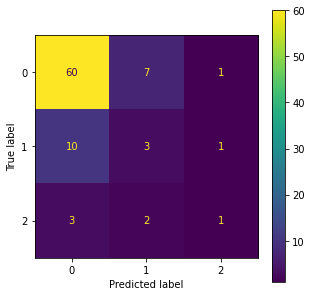

In [33]:
cm = confusion_matrix(y_test_new, y_pred_new)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)

In [34]:
# Checking SMOTE with Test Results
nsm = SMOTE(random_state=42)
x_test_reshaped = x_test.reshape(x_test.shape[0],-1)
x_test_smote, y_test_smote = nsm.fit_resample(x_test_reshaped, y_test)
x_test_smote = x_test_smote.reshape(-1, x_test.shape[1], x_test.shape[2])

In [35]:
y_pred_smote = model.predict(x_test_smote)

y_pred_dash = []
y_test_dash = []

for i in list(y_pred_smote):
    t = list(i)
    k = t.index(max(t))
#     k = 0 if i < 0.5 else 1
    y_pred_dash.append(k)

for i in list(y_test_smote):
    t = list(i)
    k = t.index(max(t))
#     k = 0 if i < 0.5 else 1
    y_test_dash.append(k)

In [36]:
print(classification_report(y_test_dash, y_pred_dash))

              precision    recall  f1-score   support

           0       0.62      0.88      0.73        68
           1       0.39      0.54      0.45        68
           2       0.67      0.12      0.20        68

    accuracy                           0.51       204
   macro avg       0.56      0.51      0.46       204
weighted avg       0.56      0.51      0.46       204



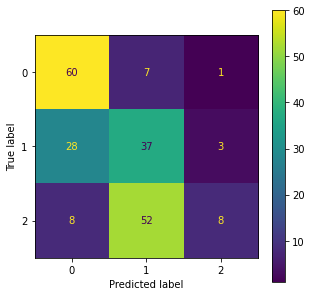

In [37]:
cm = confusion_matrix(y_test_dash, y_pred_dash)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)

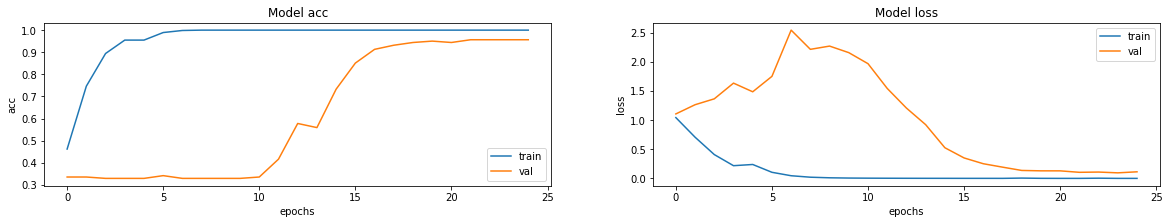

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(history[metric])
    ax[i].plot(history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


In [40]:
model.load_weights("2d_image_classification.h5")

In [41]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print("Test accuracy:", test_acc)
print("Test Loss:", test_loss)

Test accuracy: 0.7954545617103577
Test Loss: 0.6701949834823608


In [42]:
y_pred = model.predict(x_test)

In [43]:
y_pred_new = []
y_test_new = []

for i in list(y_pred):
    t = list(i)
    k = t.index(max(t))
#     k = 0 if i < 0.5 else 1
    y_pred_new.append(k)

for i in list(y_test):
    t = list(i)
    k = t.index(max(t))
#     k = 0 if i < 0.5 else 1
    y_test_new.append(k)

In [44]:
print(classification_report(y_test_new, y_pred_new))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89        68
           1       0.60      0.21      0.32        14
           2       0.33      0.17      0.22         6

    accuracy                           0.80        88
   macro avg       0.59      0.45      0.48        88
weighted avg       0.76      0.80      0.75        88



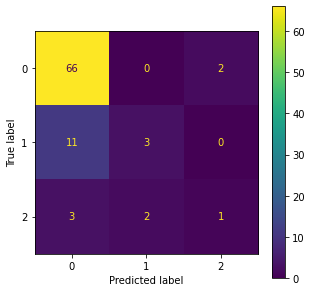

In [45]:
cm = confusion_matrix(y_test_new, y_pred_new)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)

In [46]:
test_loss, test_acc = model.evaluate(x_test_smote, y_test_smote, verbose=0)

print("Test accuracy:", test_acc)
print("Test Loss:", test_loss)

Test accuracy: 0.5147058963775635
Test Loss: 1.4299299716949463


In [47]:
y_pred = model.predict(x_test_smote)

In [48]:
y_pred_new = []
y_test_new = []

for i in list(y_pred):
    t = list(i)
    k = t.index(max(t))
#     k = 0 if i < 0.5 else 1
    y_pred_new.append(k)

for i in list(y_test_smote):
    t = list(i)
    k = t.index(max(t))
#     k = 0 if i < 0.5 else 1
    y_test_new.append(k)

In [49]:
print(classification_report(y_test_new, y_pred_new))

              precision    recall  f1-score   support

           0       0.57      0.97      0.72        68
           1       0.38      0.41      0.39        68
           2       0.73      0.16      0.27        68

    accuracy                           0.51       204
   macro avg       0.56      0.51      0.46       204
weighted avg       0.56      0.51      0.46       204



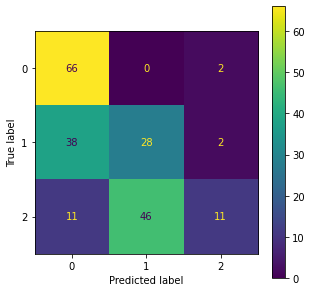

In [50]:
cm = confusion_matrix(y_test_new, y_pred_new)
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(5,5))
cmp.plot(ax=ax)